# Setup

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import re
import time
import logging
import ast
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import plotly.express as px

In [ ]:
#!pip install transformers=="4.2.2"
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir('drive/MyDrive/NLP')
DATA_DIR = "data/"

Mounted at /content/drive


# EDA

In [ ]:
notes = pd.read_csv(DATA_DIR + 'patient_notes.csv')
features = pd.read_csv(DATA_DIR + 'features.csv')
train = pd.read_csv(DATA_DIR + 'train.csv')

df = train.merge(features, how="left", on=["case_num", "feature_num"])
df = df.merge(notes, how="left", on=['case_num', 'pn_num'])

In [ ]:
print(f'There are {df.pn_num.nunique()} patients with annotation in the dataset')

There are 1000 patients with annotation in the dataset


In [ ]:
print(f'There are {notes.pn_num.nunique()} patients in the dataset')

There are 42146 patients in the dataset


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [ ]:
case_cnt = pd.DataFrame(notes.groupby(['case_num'])['case_num'].count())
case_cnt.rename(columns={'case_num': 'count'}, inplace=True)
case_cnt.reset_index(inplace=True)

In [ ]:
case_cnt

,case_num,count
0,0,2268
1,1,808
2,2,1958
3,3,9753
4,4,5405
5,5,6909
6,6,1597
7,7,4101
8,8,4196
9,9,5151


In [ ]:
fig = px.bar(case_cnt, x='case_num', y='count',barmode='group',
             width=650,
             height=400,
             text_auto=True)
fig.update_layout(yaxis_title='Number of Notes', xaxis_title='Case Number')
fig.update_xaxes(type='category')
fig.show()

In [ ]:
def transform_by_patient(df):
    df_new = pd.DataFrame(df.pn_num.unique(), 
                columns=['pn_num'])
    df['location_span'] = df.location.apply(ast.literal_eval)

    location_lst = []
    notes = []
    case = []
    for num in df.pn_num.unique():
        idx = df.pn_num == num
        locations = df.loc[idx, ['feature_num', 'location_span']]
        notes.append(df.pn_history[idx].tolist()[0])
        case.append(df.case_num[idx].tolist()[0])
        location_flat = {}
        for _, feat, loc in locations.itertuples():
            location_flat[feat] = loc
        location_lst.append(location_flat)

    df_new['case_num'] = case
    df_new['location_lst'] = location_lst
    df_new['pn_history'] = notes
    note_lens = []

    for note in notes:
        token_lst = tokenizer.tokenize(note)
        note_len = len(token_lst)
        note_lens.append(note_len)

    df_new['note_lens'] = note_lens
    feat_lens = []
    for location in df_new.location_lst:
        instance_len = [feat for feat, value in location.items() if value]
        feat_lens.append(len(instance_len))

    df_new['feat_lens'] = feat_lens

    return df_new

In [ ]:
df_patient = transform_by_patient(df)

Text(0, 0.5, 'Count')

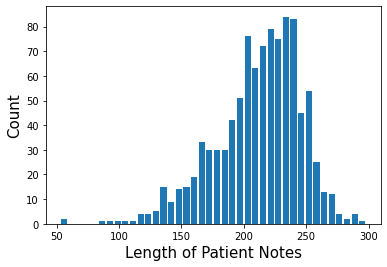

In [ ]:
note_lens = np.array(df_patient.note_lens)
n, bins, patches = plt.hist(note_lens, bins=40, rwidth=0.8)
plt.xlabel('Length of Patient Notes', fontsize=15)
plt.ylabel('Count', fontsize=15)

In [ ]:
print(f'Max note length: {np.max(note_lens)}')
print(f'Average noken length: {np.mean(note_lens)}')
print(f'Median noken length: {np.median(note_lens)}')

Max note length: 298
Average noken length: 211.663
Median noken length: 217.0


## Case-Specific Summary

In [ ]:
case_num = pd.DataFrame(df_patient.groupby(['case_num'])['case_num'].count())

In [ ]:
case_num['avg_note_lens'] = df_patient.groupby(['case_num'])['note_lens'].mean().tolist()
case_num['feature_num'] = features.groupby(['case_num'])['feature_num'].count().tolist()
case_num['avg_anno'] = df_patient.groupby(['case_num'])['feat_lens'].mean().tolist()


In [ ]:
case_num.rename(columns={'case_num': 'count'}, inplace=True)
case_num

,count,avg_note_lens,feature_num,avg_anno
case_num,,,,
0,100,209.33,13,9.98
1,100,217.48,13,9.42
2,100,225.88,17,9.98
3,100,204.11,16,11.98
4,100,203.12,10,7.46
5,100,210.29,18,11.74
6,100,212.39,12,9.71
7,100,215.58,9,6.92
8,100,224.19,18,11.90


# Potential Data Argumentation Using Exact Match

In [ ]:
pn_dict = {}
for idx, row in notes.iterrows():
    pn_dict[row['pn_num']] = row['pn_history']

In [ ]:
new_annotation = []
for case_id in features['case_num'].unique():
    
    all_pn_id = set(notes[notes['case_num']==case_id]['pn_num'].tolist())
    
    for feature_id in features[features['case_num']==case_id]['feature_num'].unique():
        # get all the pn_num that have already been annotated
        annotated_pn = set(train[train['feature_num']==feature_id]['pn_num'].tolist())
        # get all the pn_num that have NOT been annotated
        pn_to_annotate = all_pn_id-annotated_pn
        
        # get all current annotations
        # we will use them to find more annotations
        annotations = train[train['feature_num']==feature_id]['annotation'].tolist()
        annotation_texts = set()
        for a in annotations:
            anns = eval(a)
            for at in anns:
                annotation_texts.add(at)
                
        # annotate       
        for pn_id in pn_to_annotate:
            new_annotation_pn, new_location_pn = [], []
            pn_text = pn_dict[pn_id]
            for at in annotation_texts:
                start = pn_text.find(at)
                if start>=0:
                    new_annotation_pn.append(at)
                    new_location_pn.append(f'{start} {start+len(at)}')
            if len(new_annotation_pn)>0:
                new_annotation.append((
                    f'{pn_id:04d}_{feature_id:03d}',
                    case_id,
                    pn_id,
                    feature_id,
                    new_annotation_pn,
                    new_location_pn
                ))
    # break to get sample results quickly

In [ ]:
print(f'There are {len(new_annotation)} new annotations')

There are 304152 new annotations


In [ ]:
new_anno = pd.DataFrame(new_annotation, 
             columns =['id', 'case_num', 'pn_num', 'feature_num',
                   'annotation', 'location'])

In [ ]:
new_anno = new_anno.merge(features, on=['case_num', 'feature_num'], how='left')

In [ ]:
print(f'There are {new_anno.pn_num.nunique()} newly added patients')

There are 41146 newly added patients


In [ ]:
new_df_feat = new_anno.groupby(['feature_text'])['feature_text'].count().\
        reset_index(name='count').sort_values(['count'], ascending=False)

In [ ]:
new_df_feat.head()

,feature_text,count
41,Female,27828
62,Male,13318
5,35-year,13302
66,Nausea,12934
65,NSAID-use-OR-Nonsteroidal-anti-inflammatory-dr...,8054


In [ ]:
new_df_feat.tail()

,feature_text,count
14,Associated-throat-tightness,74
82,No-urinary-symptoms,39
109,Unsuccessful-napping,19
95,Recent-visit-to-emergency-department-with-nega...,13
76,No-premenstrual-symptoms,1


In [ ]:
avg_anno = new_anno.groupby(['pn_num'])['feature_text'].count().mean()